In [49]:
from dotenv import load_dotenv

load_dotenv()

True

In [50]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

llm = ChatOllama(model="llama3.2")
# llm = ChatGroq(model="llama-3.2-90b-vision-preview")


In [51]:
from pydantic import BaseModel, field_validator
from pydantic_core import ValidationError
from typing import Annotated, TypedDict
from operator import add
from langgraph.constants import Send
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


from IPython.display import display, Image

In [52]:
from pydantic import field_validator
from pydantic_core import ValidationError
from langgraph.constants import Send

class FunFacts(BaseModel):
  result: list[str] = []

  @field_validator('result')
  @classmethod
  def validate_funfacts(cls, value):
    print("_____validating")
    if len(value) < 1:
      raise ValueError("'result' cannot be EMPTY")
    return value    
  

class JokesOverallState(TypedDict):
  topic: str
  fun_facts: list[str] = []
  jokes: Annotated[list[str], add] = []
  best_ones: list[int] = []
  




llm_with_facts = llm.with_structured_output(FunFacts, include_raw=False)

## NODES
def research_fun_facts(state: JokesOverallState):
  get_facts_msg_short = f"""
  I want to find intersting and fun facts about {state['topic']}. 
  
  Requirements:
  - ONLY output the list of the fun facts
  
  Constraints:
  - DO NOT output the code.
  - DO NOT add single quote or double quotes around the output list
  
  Suggestions:
  - The number of facts should NOT exceed 5
  """
  get_facts_msg = f"""
  I want to find intersting and fun facts about {state['topic']}. 
  
  EXAMPLES:
  1. 
    - topic: bird
    - output: ['Birds have hollow bones', 'The fastest bird is the peregrine falcon', 'Birds have a highly efficient respiratory system', 'The smallest bird is the bee hummingbird', 'Birds have a unique way of communicating through songs and calls']
  2. 
    - topic: zoo
    - output: ['Zoos are involved in the conservation of many endangered species', 'The first public zoo was established in Vienna in 1752', 'The largest zoo in the world is the Henry Doorly Zoo and Aquarium in Omaha', 'Zoos provide a safe environment for animals to live and breed', 'Many zoos offer educational programs for children and adults']
  
  Requirements:
  - Return the facts in a list of string s
  - ONLY output the list of the string
  - MUST return at least one fact
  - if you didn't generate any facts, you MUST explain why
  
  
  Constraints:
  - DO NOT output the code.
  - DO NOT output any descriptions or explanations
  - DO NOT add single quote or double quotes around the output list
  
  Suggestions:
  - The number of facts should NOT exceed 5
  """
  while True:
    try:
      fun_facts = llm_with_facts.invoke([HumanMessage(content=get_facts_msg_short)])
      print(f"==> Generated fun facts\n{fun_facts}\n")
      break
    except ValidationError as e:
      print(f"!! There was a validation error: \n{e}\n")

  return {
    'fun_facts': fun_facts.result
  }
  
## Edge MapReduce
def send_facts_for_jokes(state):
  return [Send("generate_joke", {"topic": state['topic'], "fun_fact": fact}) for fact in state['fun_facts']]


In [53]:

class Jokes(BaseModel):
  result: list[str]
  
class JokeState(TypedDict):
  topic: str
  fun_fact: str

# Node
def generate_joke(state: JokeState):
  generate_jokes_msg = f"""
  Using the following fact about {state['topic']} generate a list of fun jokes
  
  fun fact: {state['fun_fact']}
  
  
  Requirements:
  - MUST ONLY output the jokes in a list of strings
  - MUST be related to the topic AND the fun fact
  
  Constraints:
  - DO NOT generate more than 3 jokes
  - DO NOT add single quote or double quotes around the output list
  
  """
  llm_with_jokes = llm.with_structured_output(Jokes)
  
  while True: 
    try:
      jokes = llm_with_jokes.invoke([HumanMessage(content=generate_jokes_msg)])
      print(f"==> $$${state['fun_fact']}$$$\nGenerated Jokes\n{jokes}\n")
      break

    except ValidationError as e:
      print(f"!! There was a validation error: \n{e}\n")
    
  return {
    'jokes': jokes.result
  }



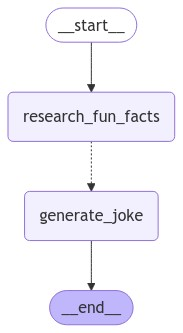

In [54]:

joke_builder = StateGraph(JokesOverallState)

joke_builder.add_node(research_fun_facts)
joke_builder.add_node(generate_joke)
# joke_builder.add_node(ToolNode(wiki_tools, name='facts_tool'))

joke_builder.add_edge(START, 'research_fun_facts')
joke_builder.add_conditional_edges('research_fun_facts', send_facts_for_jokes, ["generate_joke"])
joke_builder.add_edge('generate_joke', END)


joke_graph = joke_builder.compile()


display(Image(joke_graph.get_graph().draw_mermaid_png()))

In [55]:
joke_state = {
  'topic': "phone"
}

response = joke_graph.invoke(joke_state)


!! There was a validation error: 
5 validation errors for FunFacts
result.0
  Input should be a valid string [type=string_type, input_value={'type': 'string', 'value...al part of modern life'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
result.1
  Input should be a valid string [type=string_type, input_value={'type': 'string', 'value...imon, released in 1994'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
result.2
  Input should be a valid string [type=string_type, input_value={'type': 'string', 'value...ound 150 times per day'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
result.3
  Input should be a valid string [type=string_type, input_value={'type': 'string', 'value...action for many people'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
result.4
  Input should be a valid st

AttributeError: 'NoneType' object has no attribute 'result'

In [33]:
response

{'topic': 'phone', 'fun_facts': [], 'jokes': []}